<a href="https://colab.research.google.com/github/gopikagopikrishnan-fedus/fedl_ultrasound/blob/main/BreastCancer_3_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries

In [8]:
!pip install tensorflow

In [9]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
import warnings

print("Imported libraries")

Imported libraries


In [3]:
# 1. Install kaggle (if not already)
!pip install kaggle --upgrade

In [4]:
# 2. Upload kaggle.json (your Kaggle API key) to Colab
from google.colab import files
files.upload()   # choose kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gopikagopikrishnan","key":"eb8660a6210270feb1bbe7514d35d71b"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 57% 111M/195M [00:00<00:00, 1.16GB/s]
100% 195M/195M [00:00<00:00, 847MB/s] 


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


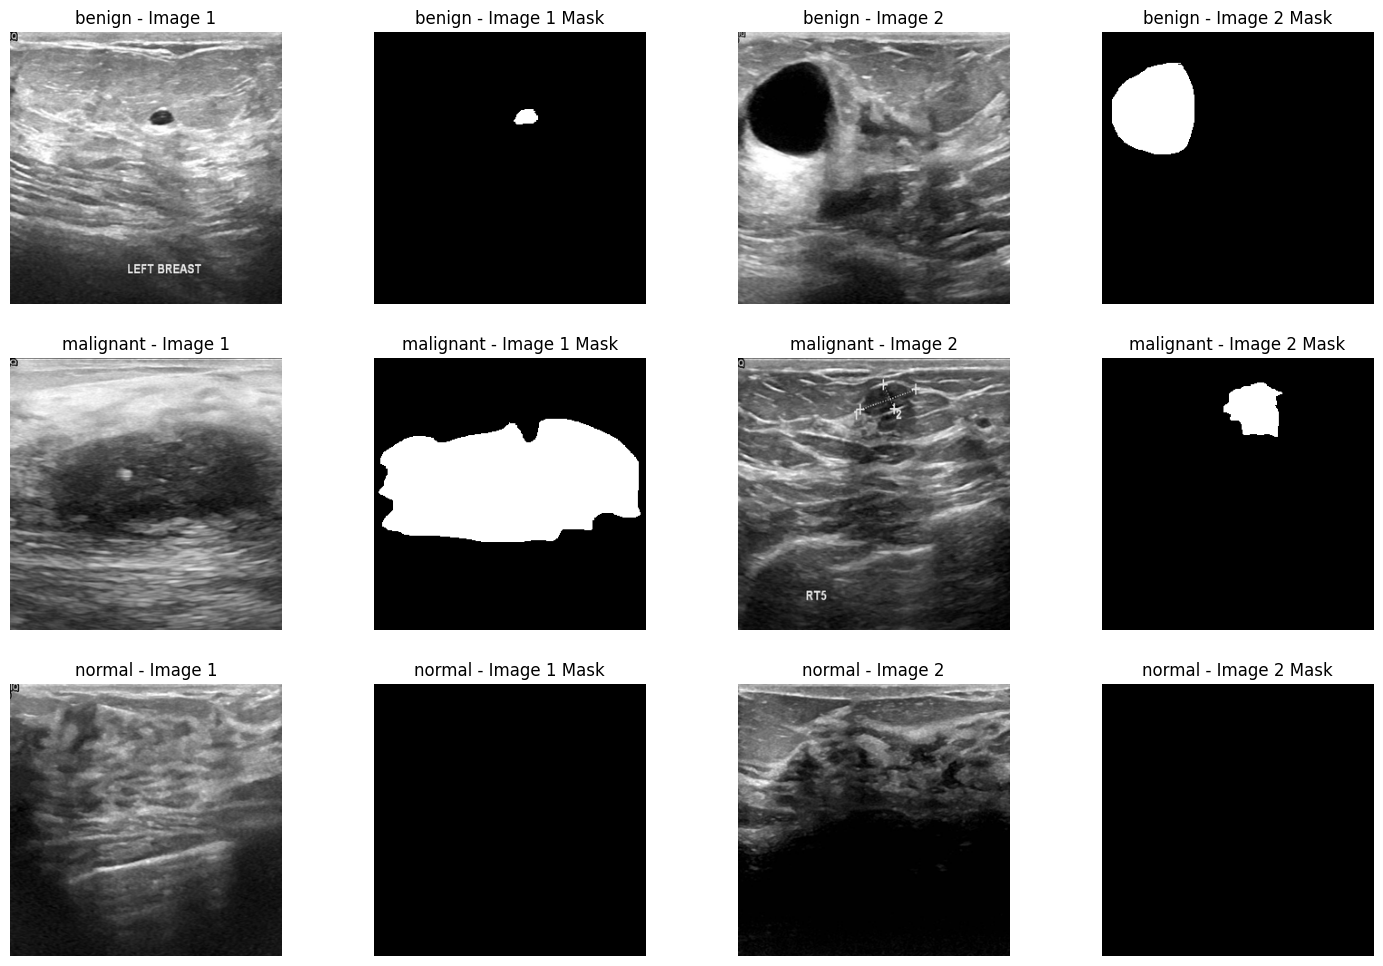

In [11]:
labels = ['benign', 'malignant', 'normal']
data_dir = '/content/data/Dataset_BUSI_with_GT'

fig, axs = plt.subplots(3, 4, figsize=(18, 12))

desired_width = 300
desired_height = 300

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)

    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]

    image_files = sorted(image_files)

    for j in range(4):
        if j < len(image_files):
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.LANCZOS)

            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'

            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

In [33]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [34]:
data_dir = '/content/data/Dataset_BUSI_with_GT'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/content/data/Dataset_BUSI_with_GT_split/train'
val_dir = '/content/data/Dataset_BUSI_with_GT_split/val'
test_dir = '/content/data/Dataset_BUSI_with_GT_split/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

Train benign: 716
Train malignant: 340
Train normal: 215
Validation benign: 181
Validation malignant: 89
Validation normal: 55
test benign: 195
test malignant: 89
test normal: 57


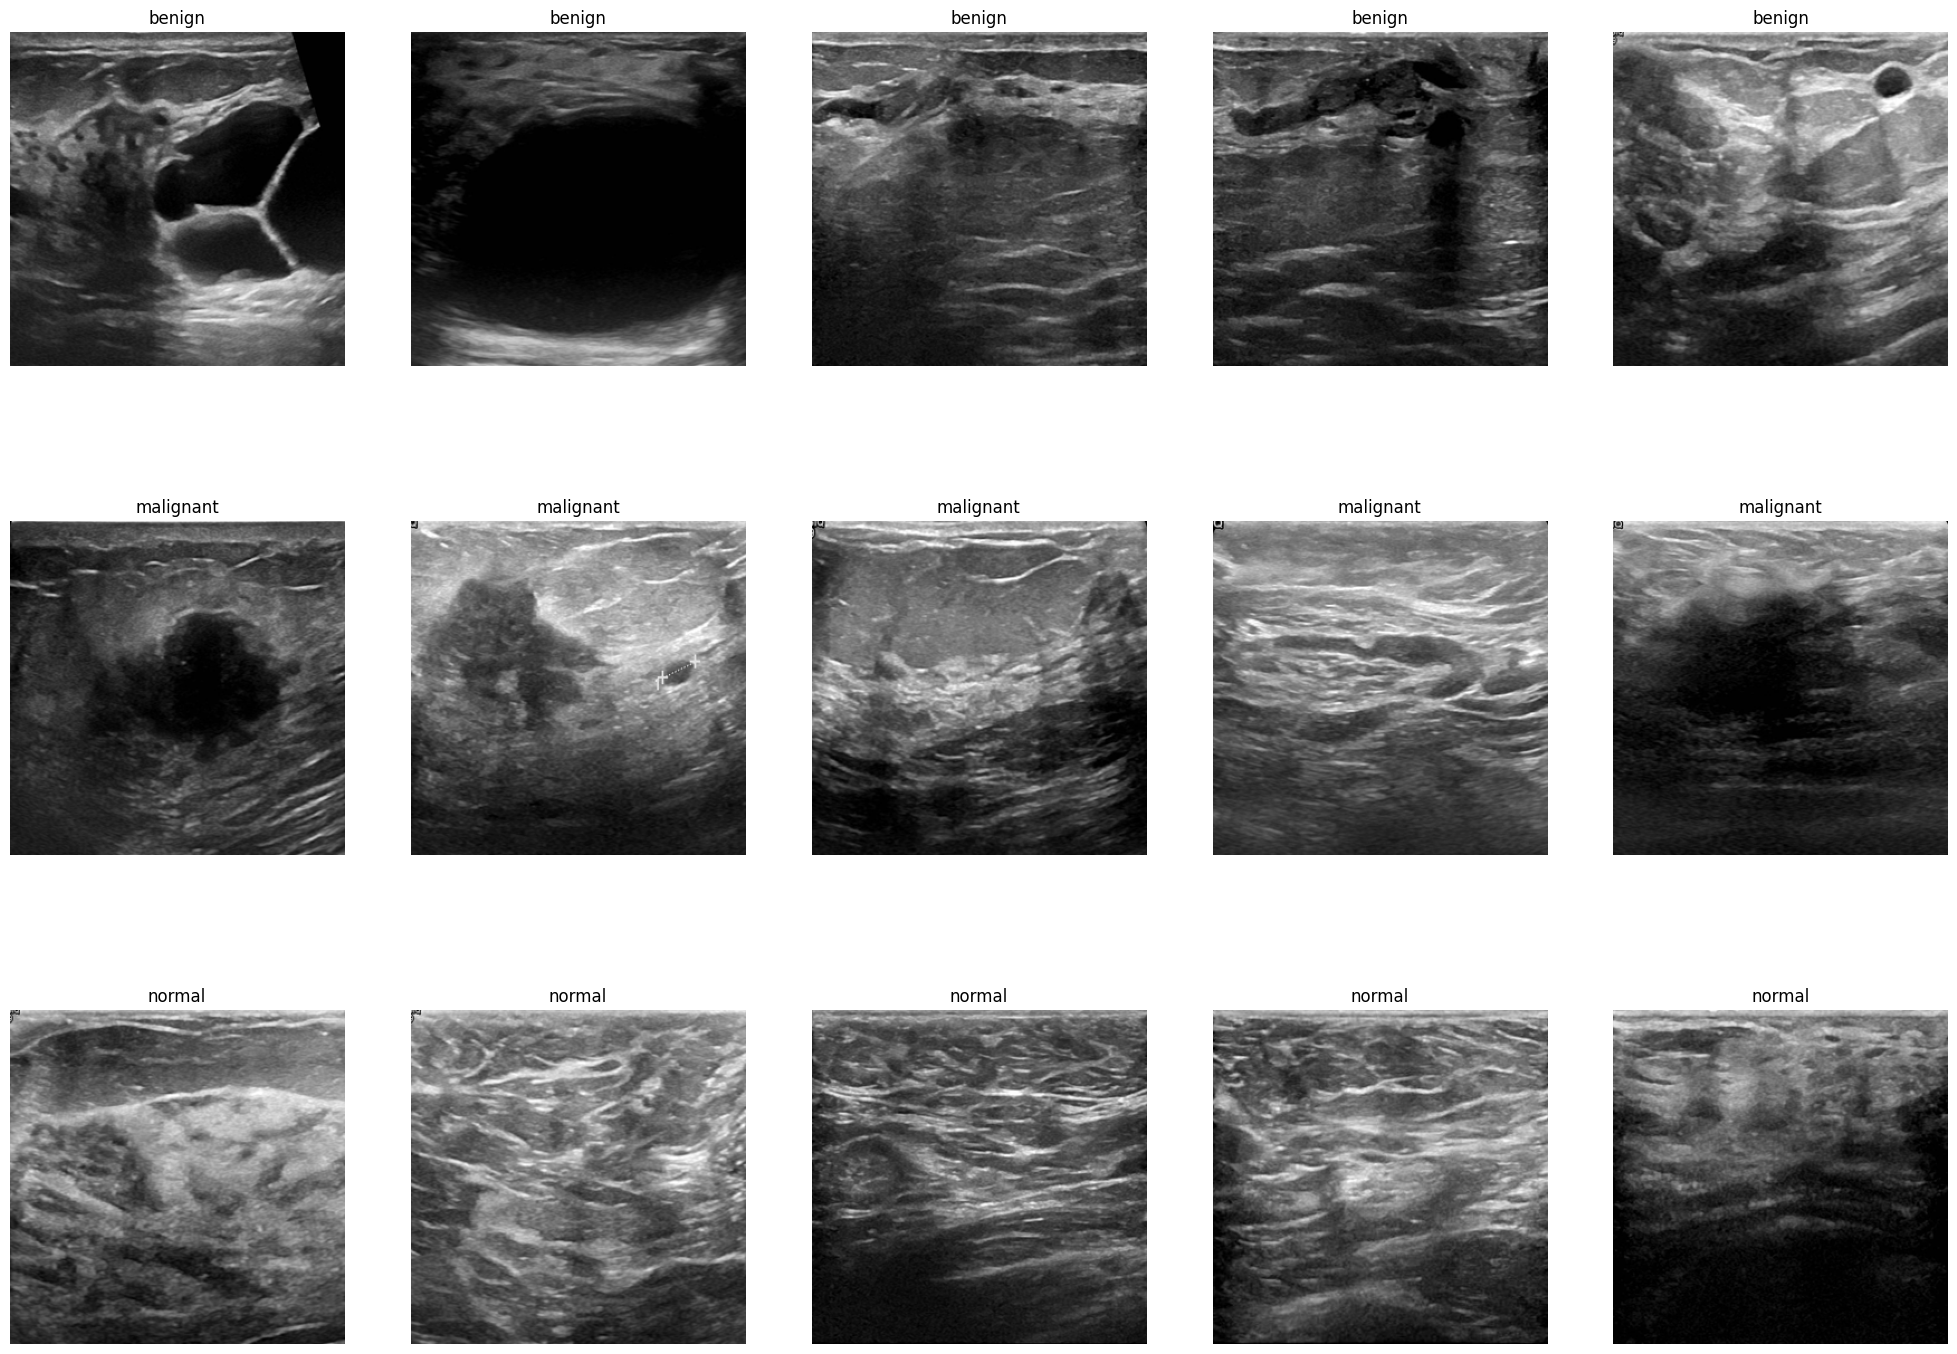

In [35]:
train_dir = '/content/data/Dataset_BUSI_with_GT_split/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/content/data/Dataset_BUSI_with_GT_split/val'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")

test_dir = '/content/data/Dataset_BUSI_with_GT_split/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")


train_dir = '/content/data/Dataset_BUSI_with_GT_split/train'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

fig, axs = plt.subplots(3, 5, figsize=(25, 18))

desired_width = 300
desired_height = 300

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.LANCZOS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')


data_dir='/content/data/Dataset_BUSI_with_GT_split'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'val', 'test']
}

In [38]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix 1:")
    print(cm)

    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Dataset Sizes: {'train': 1271, 'val': 325, 'test': 341}
Class Labels: ['benign', 'malignant', 'normal']


In [39]:
from torchvision import models
# Load the pretrained model
MobileNet = models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 39.6MB/s]


In [40]:
# Load the pretrained model
MobileNet = models.mobilenet_v3_large(pretrained=True)

# Set requires_grad = True for all parameters
for param in MobileNet.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = MobileNet.classifier[3].in_features

# Replace the last layer with a new one with output features equal to the number of classes
MobileNet.classifier[3] = nn.Linear(in_features, len(class_names))

# Move the model to the device
MobileNet_fineTuning = MobileNet.to(device)

# Define the optimizer
optimizer = optim.Adam(MobileNet_fineTuning.parameters(), lr=0.00005)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning1 = train_model_with_early_stopping(
    MobileNet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate,
    dataloaders, dataset_sizes, class_names, device,num_epochs=20, patience=2)

# Save the model
torch.save(model_fineTuning1, "/content/data/MobileNet_approach1.keras")

label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning1.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning1(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])


Epoch 0/19
----------
train Loss: 0.6976 Acc: 0.7042
val Loss: 0.5383 Acc: 0.7908

Epoch 1/19
----------
train Loss: 0.5143 Acc: 0.7962
val Loss: 0.4080 Acc: 0.8523

Epoch 2/19
----------
train Loss: 0.4338 Acc: 0.8151
val Loss: 0.2864 Acc: 0.9169

Epoch 3/19
----------
train Loss: 0.3459 Acc: 0.8686
val Loss: 0.2297 Acc: 0.9108

Epoch 4/19
----------
train Loss: 0.3005 Acc: 0.8812
val Loss: 0.2354 Acc: 0.9262

Epoch 5/19
----------
train Loss: 0.3033 Acc: 0.8828
val Loss: 0.1850 Acc: 0.9446

Epoch 6/19
----------
train Loss: 0.2343 Acc: 0.9190
val Loss: 0.2040 Acc: 0.9262

Epoch 7/19
----------
train Loss: 0.2471 Acc: 0.9095
val Loss: 0.1724 Acc: 0.9385

Epoch 8/19
----------
train Loss: 0.2173 Acc: 0.9253
val Loss: 0.1606 Acc: 0.9385

Epoch 9/19
----------
train Loss: 0.2161 Acc: 0.9166
val Loss: 0.1480 Acc: 0.9385

Epoch 10/19
----------
train Loss: 0.2018 Acc: 0.9237
val Loss: 0.1501 Acc: 0.9385

Epoch 11/19
----------
train Loss: 0.2011 Acc: 0.9245
val Loss: 0.1499 Acc: 0.9323
Ear

RuntimeError: Parent directory /kaggle/working does not exist.

In [ ]:
conv = next(m for m in model_fineTuning1.modules() if isinstance(m, torch.nn.Conv2d))
weights = conv.weight

slice = weights[0,0,:,:]

slice = slice.detach()

slice = slice.cpu()

slice_np = slice.numpy()

print(slice_np.shape)

plt.matshow(slice_np)
plt.title("Weight Slice Visualization 2")
plt.colorbar()
plt.show()

permuted = np.transpose(slice_np, (1,0))

plt.matshow(permuted)
plt.title("Permuted Weight Visualization 2")
plt.colorbar()
plt.show()

print("Slice Matrix 2= ",slice_np)


print("permuted Matrix 2= ",permuted)
